In [1]:
%cd ..

/mnt/cup/labs/hasson/zaid/fmri-convs


In [23]:
from glob import glob

import pickle
import nibabel as nib
import numpy as np
from voxelwise_tutorials.delayer import Delayer
import matplotlib.pyplot as plt
from nilearn.glm.first_level import glover_hrf
from himalaya.viz import plot_alphas_diagnostic

import pandas as pd
from nilearn import datasets
from nilearn.maskers import NiftiMasker, NiftiLabelsMasker
from util.path import Path
from constants import RUNS, NRUNS, TR, CONFOUNDS

# Visualize turns

In [3]:
sub = 32
run = 1
trial = 2
item = 2
first = "B"
conv = str(sub + 100 if sub < 100 else sub)

In [4]:
eventpath = Path(
    root="stimuli",
    conv=conv,
    datatype="transcript",
    run=run,
    set=1,
    trial=trial,
    item=item,
    condition="G",
    first=first,
    suffix="aligned",
    ext=".csv",
)
eventpath,eventpath.isfile()

(stimuli/conv-132/transcript/conv-132_run-1_set-1_trial-2_item-2_condition-G_first-B_aligned.csv,
 True)

In [15]:
df = pd.read_csv(eventpath)
df.ffill(inplace=True)
df

,speaker,sentence,word,start,end,score
0,132,1,"Uh,",3.400,3.500,0.696
1,132,1,I,4.981,5.061,0.727
2,132,1,feel,5.081,5.221,0.719
3,132,1,like,5.241,5.321,0.990
4,132,1,I,5.381,5.421,0.201
...,...,...,...,...,...,...
483,132,2,then,175.670,175.793,0.149
484,132,2,I,175.813,175.833,0.050
485,132,2,don't,175.854,176.467,0.296
486,132,2,want,176.487,176.630,0.284


In [16]:
df[df.isna().sum(1).astype(bool)]

,speaker,sentence,word,start,end,score


In [17]:
xaxis = np.arange(180 * 1000) / 1000

upto = int(df.start.max() * 1000) + 1
subA = np.zeros(180000)
subA[(df[df.speaker == sub].start * 1000).astype(int)] = 1

subB = np.zeros_like(subA)
subB[(df[df.speaker != sub].start * 1000).astype(int)] = 1

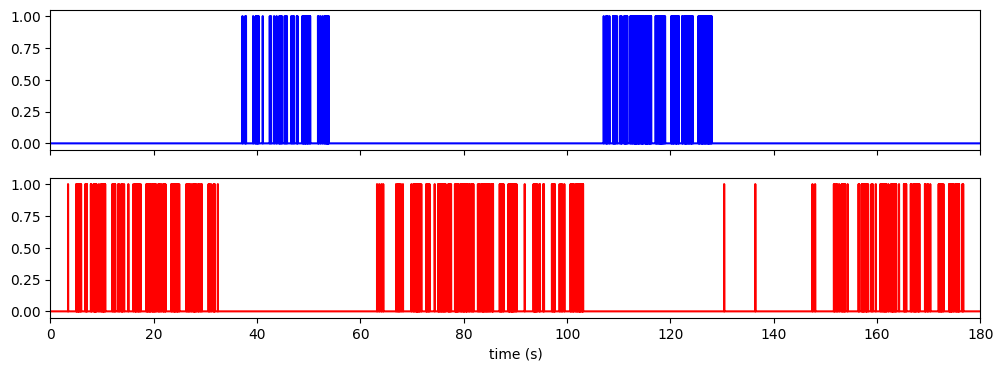

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
axes[0].set_xlim(0, 180)
axes[0].plot(xaxis, subA, color="blue")
axes[1].plot(xaxis, subB, color="red")
axes[1].set_xlabel("time (s)")
fig.show()

# Loading data

In [6]:
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=1000, resolution_mm=2)

In [81]:
# MNI
boldpath = Path(
    root="data/derivatives/fmriprep",
    sub=f"{sub:03d}",
    ses="1",
    datatype="func",
    task="Conv",
    run=1,
    space="MNI152NLin2009cAsym",
    desc="preproc",
    suffix="bold",
    ext=".nii.gz",
)

maskpath = boldpath.copy()
maskpath.update(desc='brain', suffix='mask')

boldpath

data/derivatives/fmriprep/sub-004/ses-1/func/sub-004_ses-1_task-Conv_run-1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz

In [19]:
# surface
boldpath = Path(
    root="data/derivatives/fmriprep",
    sub=f"{sub:03d}",
    ses="1",
    datatype="func",
    task="Conv",
    run=1,
    space="fsaverage6",
    hemi="L",
    suffix="bold",
    ext=".func.gii"
)

boldpath

data/derivatives/fmriprep/sub-032/ses-1/func/sub-032_ses-1_task-Conv_run-1_space-fsaverage6_hemi-L_bold.func.gii

In [25]:
from nilearn import signal

In [24]:
data = nib.load(boldpath)

In [28]:
bold = data.agg_data()
bold.shape

(40962, 544)

In [29]:
newd = signal.clean(bold.T)

/tmp/ipykernel_165287/678679344.py:1: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  newd = signal.clean(bold.T)
